# Clasificación de imágenes (CIFAR-10 dataset)

En este Notebook muestra cómo clasificar un datset de 60.000 imágenes para su correcta clasificación. Este es un claro ejemplo de clasificación, para lo cual se aplicará una red neuronal profunda convolucional (CNN) que terminará en una capa de salida densa fully-connected del tamaño del número de etiquetas del que consta dataset.

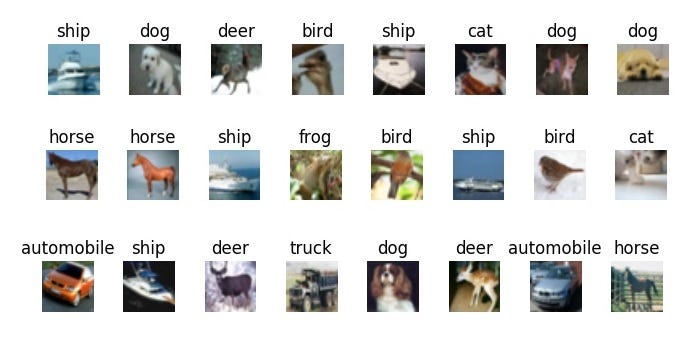

In [6]:
# Importación de las librerías
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical

# Para silenciar posibles warnings de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Se está trabajando con una versión de Python 3.5.2 (Anaconda) y con una versión de TensorFlow:

In [7]:
tf.__version__

'2.17.1'

## Obtención de los datos

El dataset CIFAR-10 tiene un tamaño aproximado de 170 MB y se descargará automáticamente desde los tutoriales de ejemplo de Keras.

In [8]:
from keras.datasets import cifar10


Está compuesto por 50.000 imágenes de entrenamiento y 10.000 imágenes de testeo, cada una con su correspondiente etiqueta (label). Se carga el dataset con la función load_data():

In [9]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


La dimensión de cada una de las imágenes es de `(32,32,3)`, con una altura y anchua de 32 píxeles y 3 canales RGB.

In [10]:
num_train, img_channels, img_rows, img_cols =  train_images.shape
num_train, img_channels, img_rows, img_cols


(50000, 32, 32, 3)

In [11]:
num_test, _, _, _ =  test_images.shape
num_test, img_channels, img_rows, img_cols

(10000, 32, 32, 3)

### Función para representación de las imágenes del dataset

En el CIFAR-10 dataset se disponen de imágenes de 10 clases distintas: aviones, coches, pájaros, perros, gatos, cérvidos, ranas, equinos, barcos y camiones:


In [12]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

Se fabrica una función de representación de imágenes sencilla juntos con sus etiquetas:

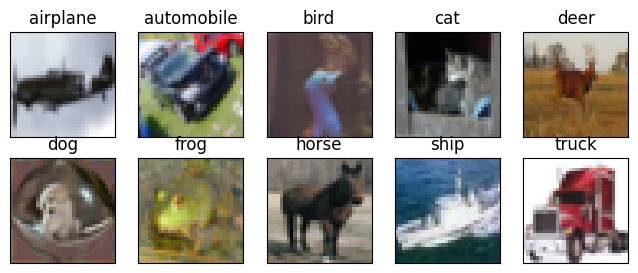

In [13]:
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels == i)[0]
    features_idx = train_images[idx]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Preprocesado de los datos

#### One-Hot Encoding de las etiquetas

La etiqueta de cada imagen se ha convertido de un número a un vector cuya longitud equivale al número de clases posibles. Para una determinada etiqueta correspondiente a un número `i`, se muestra que todos los elementos de ese array son `0` salvo el elemento i-ésimo, que se deja como un `1`. Por ejemplo:

In [15]:
# Normalización del train y el test dataset entre 0 y 1
train_features = train_images.astype('float32') / 255.
test_features = test_images.astype('float32') / 255.

# Conversión de las etiquetas a variables One-Hot Encoded

num_classes = len(np.unique(train_labels))

train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

Con esto ya se tienen preparados los datos para poder hacer uso en el entrenamiento de un modelo de clasificación:

### Definición de una red convolucional haciendo uso de Keras

La estructura de datos principal en Keras es un modelo (`model`), que está pensada para facilitar la organización de capas, pues en realidad los modelos en Keras son básicamente una secuencia de capas. La clase `keras.models.Sequential` es una envoltura para el modelo de red neuronal.

Secuencialmente se concatenan las capas convolucionales con densas, fully connected, capas de max pool, capas de activación, etc. Se puede agregar fácilmente una capa al modelo mediante su función `add()` sin preocuparse de las dimenasionalidades de los inputs a cada capa. Por ejemplo, un modelo para el caso se construiría de la siguiente manera:

In [16]:
# Definición del modelo
# Inicia el modelo de manera secuencial
model = Sequential()

# Agregación al modelo de las capas sin preocuparse de la dimensionalidad de los inputs
# salvo en la primera capa
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
                 input_shape=train_features.shape[1:]))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))


# Ejecutar un flattening de la última capa de Pooling,
# significa transformar la salida de una capa convolucional o de pooling
# (que generalmente tiene forma de matriz multidimensional) en un vector unidimensional.
model.add(Flatten())

model.add(Dense(units=512, activation = 'relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(units=num_classes, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Keras** permite visualizar un resumen del modelo construido, dándo detalles de las dimensiones de los outputs de cada capa y del número de parámetros que estarán involucrados en el entrenamiento del modelo. Para acceder a ese resumen, basta con ejecutar el siguiente comando:

In [17]:
# Model summary y ploteo del grafo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Se requiere el entrenamiento de más de 1,2 millones de parámetros en el modelo.

Ahora el modelo debe compilarse. Para ello, se usa la función `compile()` indicando el optimizador a usar, la función de pérdida a usar y la métrica a monitorizar durante el entrenamiento.

In [18]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Verificar que se tiene una carpeta creada para el almacenamiento del checkpoint del modelo.

In [19]:
checkpoint_dir = os.getcwd() + '/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

## Entrenamiento del modelo

Con las siguientes líneas se inicia el entrenamiento del modelo:



In [24]:
# Define el directorio donde guardar los checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Cambia la extensión a .keras
filepath = os.path.join(checkpoint_dir, "weights.best.keras")

# Configuración del checkpoint
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',  # Se utiliza 'val_accuracy' en lugar de 'val_acc'
    verbose=1,
    save_best_only=True,  # Solo guarda el mejor modelo
    mode='auto'
)

callbacks_list = [checkpoint]

# Ajuste del modelo
start = time.time()

model_info = model.fit(
    train_features, train_labels,
    batch_size=128,
    epochs=10,  # 'nb_epoch' se reemplaza por 'epochs'
    validation_data=(test_features, test_labels),
    callbacks=callbacks_list,
    verbose=1
)

end = time.time()

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.3177 - loss: 1.8395
Epoch 1: val_accuracy improved from -inf to 0.53420, saving model to ./checkpoints/weights.best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 209s 529ms/step - accuracy: 0.3180 - loss: 1.8388 - val_accuracy: 0.5342 - val_loss: 1.2740
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5623 - loss: 1.2212
Epoch 2: val_accuracy improved from 0.53420 to 0.63410, saving model to ./checkpoints/weights.best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 260s 524ms/step - accuracy: 0.5624 - loss: 1.2211 - val_accuracy: 0.6341 - val_loss: 1.0542
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6457 - loss: 1.0038
Epoch 3: val_accuracy improved from 0.63410 to 0.69450, saving model to ./checkpoints/weights.best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 260s 520ms/step - accuracy: 0.6457 - loss: 1.0037 - val_accuracy: 0.6945 - val_loss: 0.8763
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accur

### Función que permitirá monitorizar la evolución de la precisión y la función de pérdida

In [37]:
def plot_model_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    # Resumen de la evolución de la precisión
    ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    ax[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    ax[0].set_ylabel('Precisión')
    ax[0].set_xlabel('Época')

    # Corregir el cálculo del paso (ticks) en el eje X
    ax[0].set_xticks(np.arange(1, len(history.history['accuracy']) + 1, len(history.history['accuracy']) // 10))
    ax[0].legend(['Entrenamiento', 'Validación'], loc='best')

    # Resumen de la evolución de la función de pérdida
    ax[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    ax[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    ax[1].set_ylabel('Pérdida')
    ax[1].set_xlabel('Época')

    # Corregir el cálculo del paso (ticks) en el eje X
    ax[1].set_xticks(np.arange(1, len(history.history['loss']) + 1, len(history.history['loss']) // 10))
    ax[1].legend(['Entrenamiento', 'Validación'], loc='best')

    plt.show()

### Definición de una función para calcular la precisión de la prueba (test)

In [38]:
def accuracy(test_image, test_label, model):

    # Haciendo uso de model.predict
    result = model.predict(test_image)

    # La predicción de la clase se obtiene haciendo uso de np.argmax()
    predicted_class = np.argmax(result, axis=1)

    # La clase verdadera del test dataset,
    # se usa para compararla con la clase predicha
    true_class = np.argmax(test_label, axis=1)

    # Calcula la precisión sobre el test dataset del clasificador
    num_correct = np.sum(predicted_class == true_class)
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Keras facilita una manera muy rápida de evaluar el desempeño del modelo con la función `evaluate()`. No es necesario una función como la anterior para calcular la accuracy.

In [39]:
# Bondad del modelo entrenado teniendo en cuenta el test dataset.
scores = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7736 - loss: 0.6564
Test loss: 0.6559990048408508
Test accuracy: 0.7759000062942505


Como resumen del entrenamiento (train) y de la prueba (test), a continuación se ofrece:

1. Evolución de la precisión y de la función de pérdida.
2. Precisión sobre el test dataset.

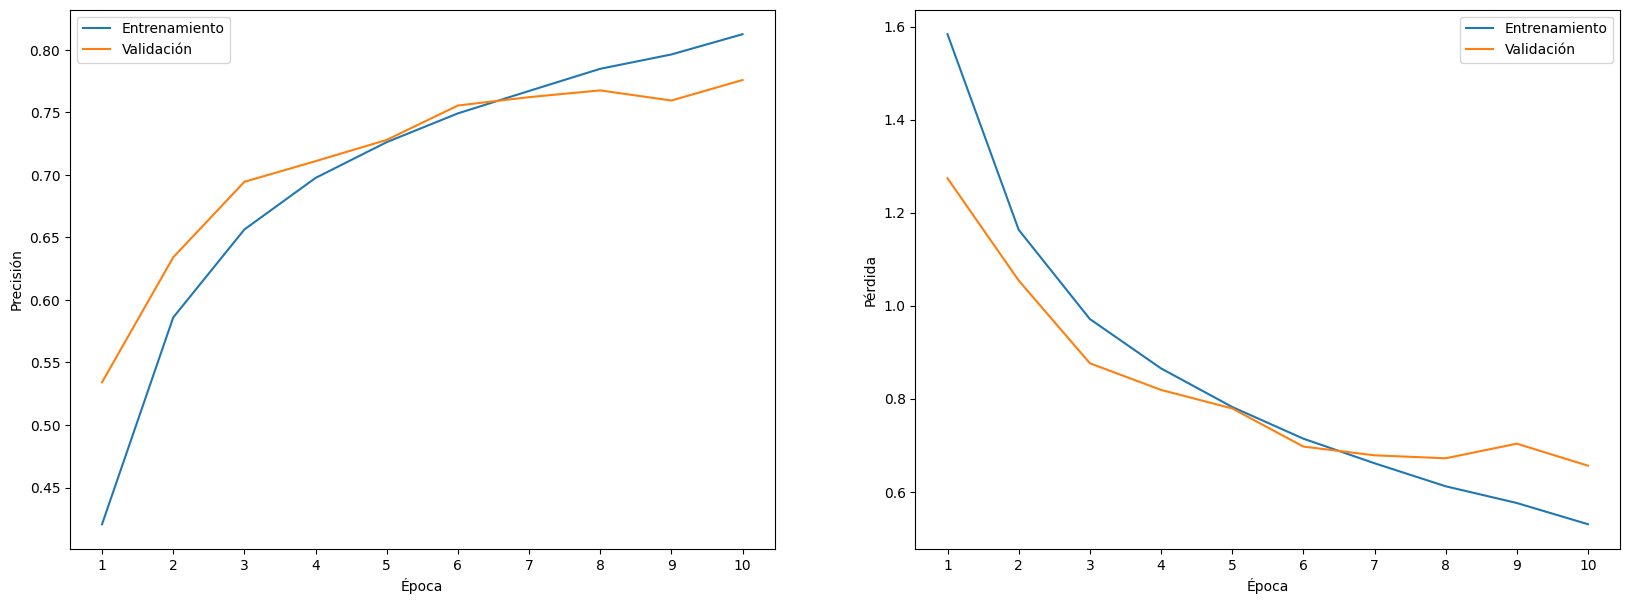

El entrenamiento del modelo duró 2374.19 segundos
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
La precisión (Accuracy) sobre el test dataset es del: 77.59 %


In [40]:
plot_model_history(model_info)
print("El entrenamiento del modelo duró %0.2f segundos"%(end - start))

# compute test accuracy
print("La precisión (Accuracy) sobre el test dataset es del: %0.2f %%" %accuracy(test_features, test_labels, model))